<a href="https://colab.research.google.com/github/Lchet/PlantView/blob/main/Plant_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract
The purpose of the notebook is to build an image classifier for plant disease. The data set contain images from [***Kaggle PlantVillage Dataset***](https://www.kaggle.com/emmarex/plantdisease/code?datasetId=70909&sortBy=voteCount)

Once, classifier is built we will try to do a segmentation for the disease (if classified as True) 

I will use data augmentation and clustering technique for segmentation

# Get Files and Load dataset
This section get the zip files from github into colab env


##Arrage Kaggle env. api

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=030396c1760594b562d37750be8eb885c086b6ea1cd630b450405fd52d2dc710
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          17911       1393  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          10655        755  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5302        346  1.0              
dhruvildave/wikibooks-dataset                           

In [ ]:
! kaggle datasets download --force -d emmarex/plantdisease

 98% 642M/658M [00:02<00:00, 220MB/s]
100% 658M/658M [00:02<00:00, 245MB/s]


In [ ]:
!unzip "/content/plantdisease.zip" -d "/content/data/"

In [ ]:
!rm  -r '/content/data/plantvillage'/ 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
working_dir = r"/content/drive/MyDrive/Colab Notebooks/PlantView"

Mounted at /content/drive


In [ ]:
img_path = r'/content/data/PlantVillage'

## Load Dataset and Utils
Below several functions utils to load the data.
1. `get_label_frequencies` - get number of samples per disease - go through files direcorties
2. `get_plant_df` - create data frame thanincludes image file, disease type, plant type. 

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [ ]:
len(os.listdir(img_path))

15

In [ ]:
plants_directories = os.listdir(img_path)

In [ ]:
## Get the number of files per each directory in dataset
def n_files_per_dir(dir_list):
  dir_dic = {'directory':[], 'num_of_images':[]}
  for directory in dir_list:
      num_of_files = len(os.listdir(f'{img_path}/{directory}'))
      dir_dic['directory'].append(directory)
      dir_dic['num_of_images'].append(num_of_files)
  return pd.DataFrame(dir_dic)

In [ ]:
samples_count = n_files_per_dir(plants_directories)

In [ ]:
samples_count.sort_values(by=['num_of_images'])

directory  num_of_images
12                             Potato___healthy            152
2                   Tomato__Tomato_mosaic_virus            373
10                             Tomato_Leaf_Mold            952
3                 Pepper__bell___Bacterial_spot            997
6                           Tomato_Early_blight           1000
7                          Potato___Late_blight           1000
13                        Potato___Early_blight           1000
5                           Tomato__Target_Spot           1404
0                        Pepper__bell___healthy           1478
1                                Tomato_healthy           1591
8   Tomato_Spider_mites_Two_spotted_spider_mite           1676
11                    Tomato_Septoria_leaf_spot           1771
9                            Tomato_Late_blight           1909
4                         Tomato_Bacterial_spot           2127
14        Tomato__Tomato_YellowLeaf__Curl_Virus           3209

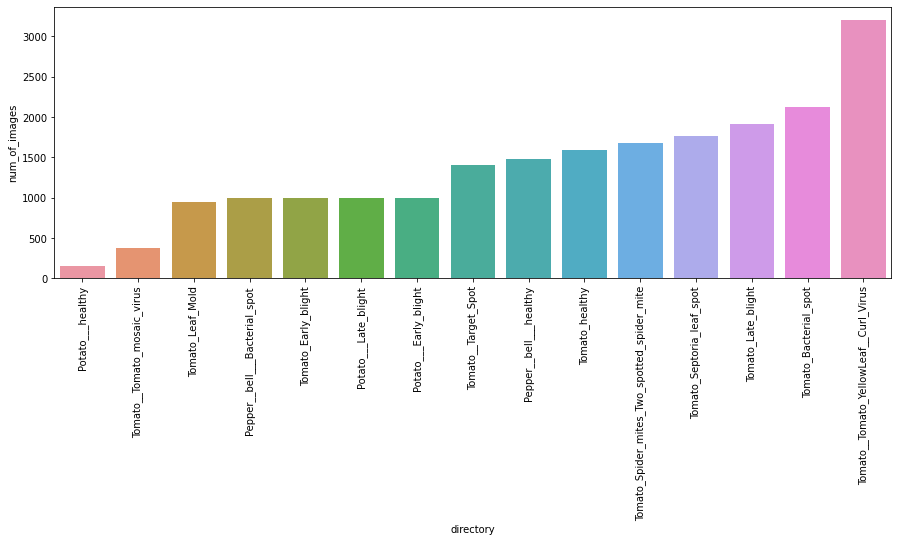

In [ ]:
plt.figure(figsize=(15,5))
samples_count.num_of_images.sort_values()
sns.barplot(x='directory', y = 'num_of_images', data=samples_count.sort_values(by=['num_of_images']))
plt.xticks(rotation=90)
plt.show()

In [ ]:
disease_cls = ['healthy', 'septoria_leaf_spot', 'leaf_mold', \
                  'early_blight', 'mosaic_virus', 'late_blight', \
                  'spider_mite', 'bacterial_spot', 'target_spot', \
                  'curl_virus']

plants = ['tomato', 'pepper', 'potato']

In [ ]:
## dataframe of file names and labels
def get_plant_df():

  def get_plant_disease(long_label):
    disease_found = False
    plant_found = False
    returned_plant, returned_disease = None, None
    for plant in plants:
      if plant in long_label.lower() and not plant_found:
        returned_plant = plant
        plant_found = True
    for disease in disease_cls:
      if disease in long_label.lower() and not disease_found:
        returned_disease = disease
        disease_found - True
        
    return returned_plant, returned_disease
         
  file_ext = ['jpg', 'png']  
  data_dic = {'plant': [], 'disease':[], 'file_path':[], 'directory':[]}
  for plant_disease in plants_directories:
      plant_name, disease = get_plant_disease(plant_disease)
      if (plant_name == None) or (disease == None):
        print(f'plant: {plant_name}, disease: {disease}, long_label: {plant_disease}, path: {img_path}/{plant_disease}')
      for file_name in os.listdir(f'{img_path}/{plant_disease}'):
        if file_name[-3:].lower() in file_ext:
          data_dic['plant'].append(plant_name)
          data_dic['disease'].append(disease)
          data_dic['file_path'].append(f'{img_path}/{plant_disease}/{file_name}')
          data_dic['directory'].append(plant_disease)
  return pd.DataFrame(data_dic)     

## Data Explorations

In [ ]:
data_df = get_plant_df()

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20637 entries, 0 to 20636
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   plant      20637 non-null  object
 1   disease    20637 non-null  object
 2   file_path  20637 non-null  object
 3   directory  20637 non-null  object
dtypes: object(4)
memory usage: 645.0+ KB


In [ ]:
data_df.sample(5)

plant  ...                      directory
7741   tomato  ...            Tomato__Target_Spot
11707  tomato  ...             Tomato_Late_blight
4145   pepper  ...  Pepper__bell___Bacterial_spot
6791   tomato  ...            Tomato__Target_Spot
16888  potato  ...          Potato___Early_blight

[5 rows x 4 columns]

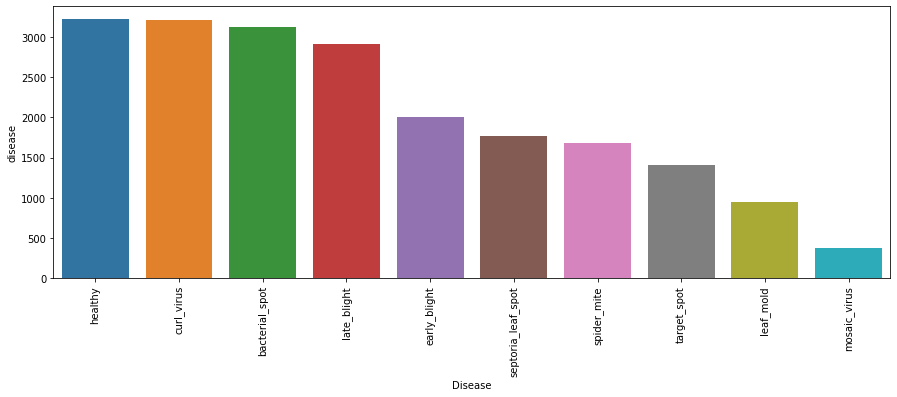

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x=data_df.disease.value_counts().index, y=data_df.disease.value_counts())
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.show()

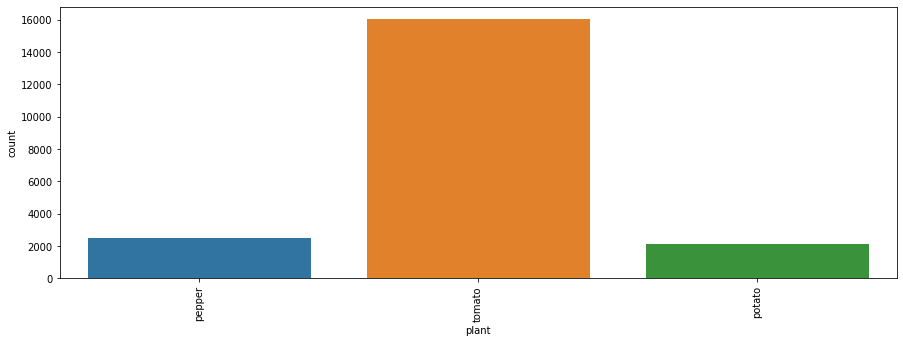

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(x='plant', data=data_df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Display images for different species
import math
def show_img_from_data(disease_directory, num):

  for disease in disease_directory:
    sample_df = data_df[data_df.directory == disease].sample(num)
    fig, ax = plt.subplots(1, num, figsize=(12, 12))
    
    for index in range(num):
      image_path = sample_df.file_path.iloc[index]
      ax[index].set_xticks([])
      ax[index].set_yticks([])
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      ax[index].imshow(image)
    title = f'{sample_df.plant.iloc[index]}, {sample_df.disease.iloc[index]}, {image.shape[1::-1]}'
      
    ax[math.floor(num/2)].set_title(title)

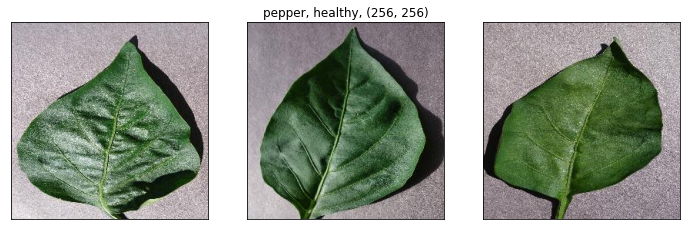

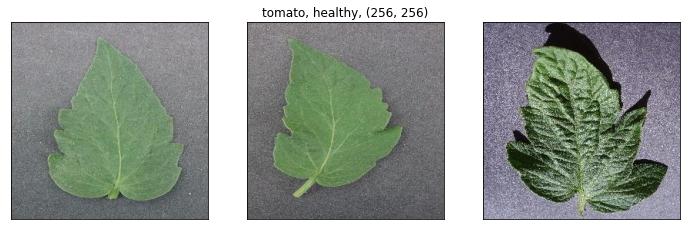

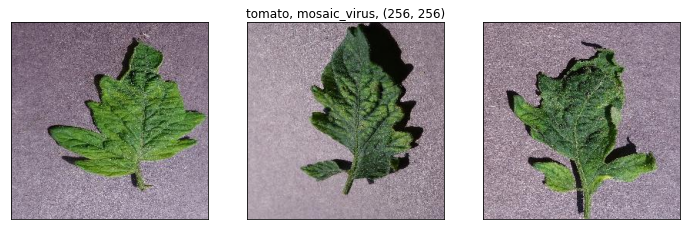

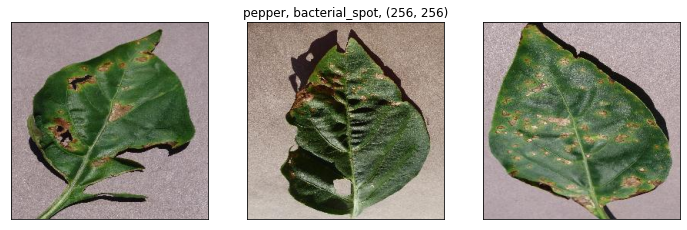

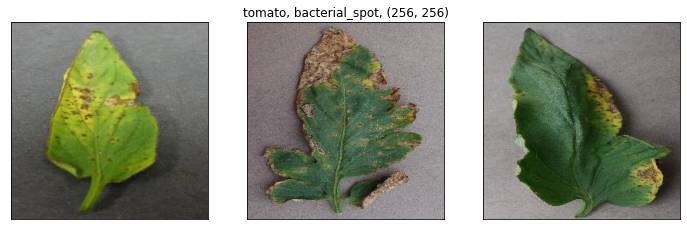

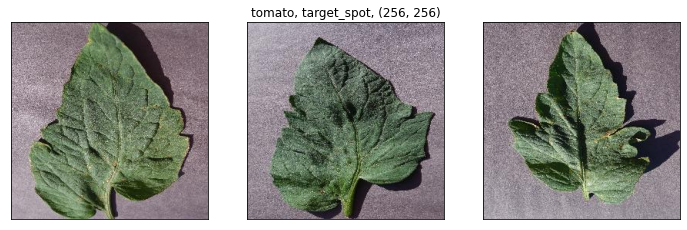

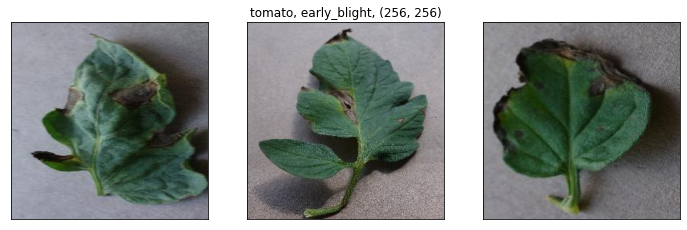

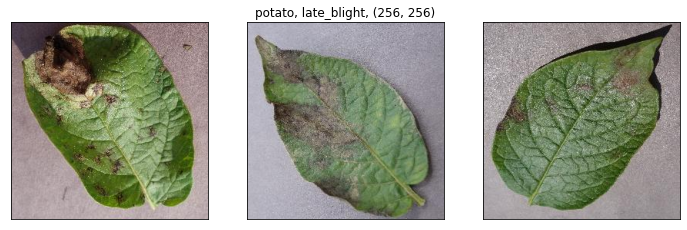

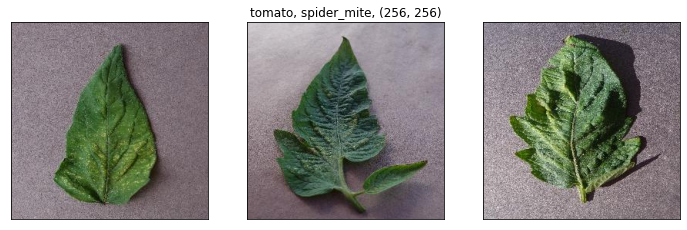

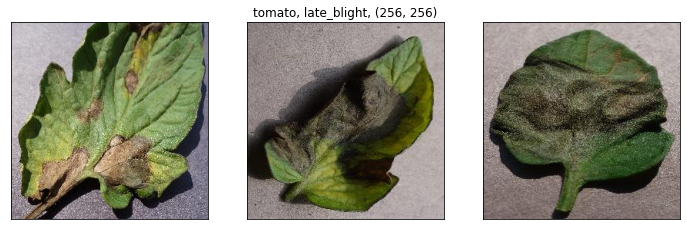

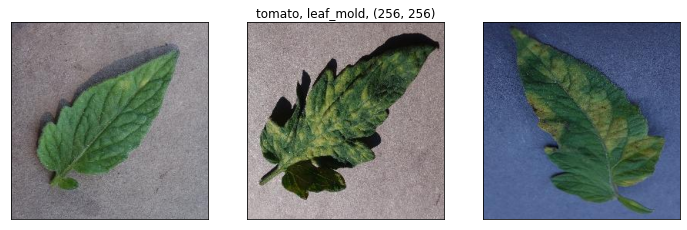

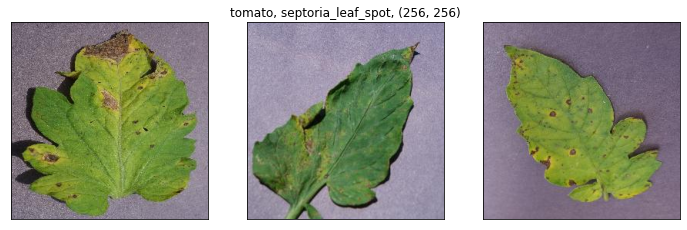

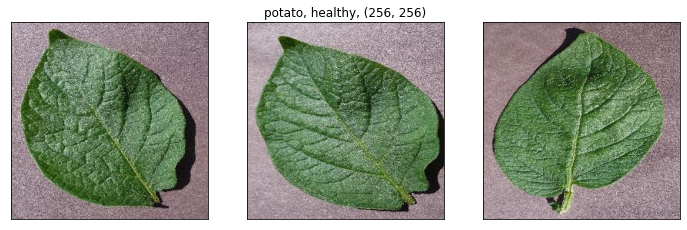

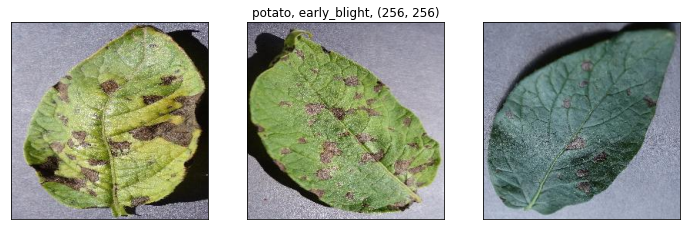

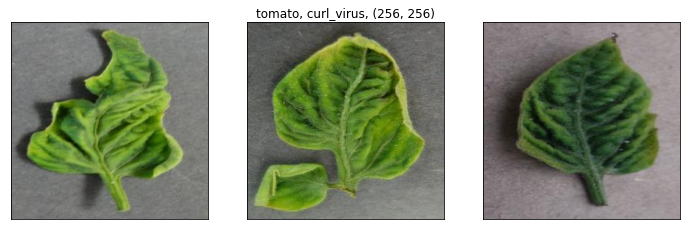

In [ ]:
show_img_from_data(plants_directories, 3)

## Build Model

### Build Model Class

#### Model Hyper params

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 50
INIT_LR = 1e-3
BATCH_SIZE = 32
IMAGE_DIMS = (256, 256, 3)

#### Class

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import keras as keras
import tensorflow as tf

In [ ]:
class PlantVillage:
  @staticmethod
  def build_disease_branch(inputs, num_diseases, 
                            activation="softmax",
                            channels=-1):
    
    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=channels)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    # (CONV => RELU) * 2 => POOL
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=channels)(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=channels)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    # (CONV => RELU) * 2 => POOL
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=channels)(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=channels)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    # define a branch of output layers for the number of different
    # disease categories 
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_diseases)(x)
    x = Activation(activation=activation, name="disease_output")(x)
  
    return x

  @staticmethod
  def build_plant_branch(inputs, num_plants, 
                          activation="softmax",
                          channels=-1):
    # CONV => RELU => POOL
    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=channels)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=channels)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=channels)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    # define a branch of output layers for the number of different
    # plants 
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_plants)(x)
    x = Activation(activation=activation, name="plant_output")(x)
    # return the color prediction sub-network
    return x

  @staticmethod
  def build(height, width, num_diseases, 
             num_plants, activation="softmax"):
   
    input_shape = (height, width, 3)
    channels = -1
    # construct both the "category" and "color" sub-networks
    inputs = Input(shape=input_shape)
    plant_branch = PlantVillage.build_plant_branch(inputs, 
                                                  num_plants, 
                                                  activation = activation, 
                                                  channels = channels)
                                                                                                  
    disease_branch = PlantVillage.build_disease_branch(inputs, 
                                                  num_diseases, 
                                                  activation = activation, 
                                                  channels = channels)
      
    model = Model(inputs=inputs, 
                outputs=[disease_branch, plant_branch], 
                name="plant_village")
    # return the constructed network architecture
    return model


### Build Datasets for model

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

#### Function for preproccessing the dataset

In [ ]:
def load_images(element, y=None):
  image = tf.io.read_file(element)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.resize(image, IMAGE_DIMS[:-1])
  return image, y

In [ ]:
def aug_img(images, labels, aug=None):
	# pass a batch of images through our data augmentation pipeline
	# and return the augmented images
  if aug!=None:
    images = aug(images)
  else:
	# return the image and the label

    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.rot90(images)
  return (images, labels)

In [ ]:
train_aug = keras.Sequential([ 
                              keras.layers.RandomFlip("horizontal_and_vertical"),
                              keras.layers.RandomZoom(
                                height_factor=(-0.05, -0.15),
                                width_factor=(-0.05, -0.15)),
                              keras.layers.RandomRotation(0.3)
                             ])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# this functions get labels values and returns classes list, 
# number of classes and a weighted dictionary of the classes in labels

def get_class_weights(labels, verbose = 0):
  weights = compute_class_weight('balanced',  classes= np.unique(labels), y=labels)
  # creating a dictionary that will be used later for the model fit
  dict_weights = dict(zip(np.arange(len(np.unique(labels))), weights))
  classes = np.unique(labels)
  n_classes = len(classes)
  if verbose:
    print(f"classes: {classes}")
    print(f"n_classes: {n_classes}")
    print(f"dict_weights: {dict_weights}")
    print("==============")
    display(labels.value_counts())

  return classes, n_classes, dict_weights

In [ ]:
# creating a dictionary that will be used later for the model fit
disease_cls, n_diseases, disease_dict_weights = get_class_weights(data_df.disease, verbose=1)
plant_cls, n_plants, plant_dict_weights = get_class_weights(data_df.plant, verbose=1)

classes: ['bacterial_spot' 'curl_virus' 'early_blight' 'healthy' 'late_blight'
 'leaf_mold' 'mosaic_virus' 'septoria_leaf_spot' 'spider_mite'
 'target_spot']
n_classes: 10
dict_weights: {0: 0.660595390524968, 1: 0.6432980049875312, 2: 1.03185, 3: 0.640701645451723, 4: 0.7096629986244842, 5: 2.167752100840336, 6: 5.5327077747989275, 7: 1.1652738565782044, 8: 1.231324582338902, 9: 1.469871794871795}


healthy               3221
curl_virus            3208
bacterial_spot        3124
late_blight           2908
early_blight          2000
septoria_leaf_spot    1771
spider_mite           1676
target_spot           1404
leaf_mold              952
mosaic_virus           373
Name: disease, dtype: int64

classes: ['pepper' 'potato' 'tomato']
n_classes: 3
dict_weights: {0: 2.7793939393939393, 1: 3.1965613382899627, 2: 0.4296689569019363}


tomato    16010
pepper     2475
potato     2152
Name: plant, dtype: int64

#### Dataset

In [ ]:
# binarize both sets of labels
plant_LB = LabelBinarizer()
disease_LB = LabelBinarizer()
disease_labels = disease_LB.fit_transform(data_df.disease)
plant_labels = plant_LB.fit_transform(data_df.plant)
print(f'disease_labels.shape: {disease_labels.shape}')
print(f'plant_labels.shape: {plant_labels.shape}') 
print(f'plant_LB.class_: {plant_LB.classes_}')
print(f'disease_LB.class_: {disease_LB.classes_}')

[INFO] binarizing labels...
disease_labels.shape: (20637, 10)
plant_labels.shape: (20637, 3)
plant_LB.class_: ['pepper' 'potato' 'tomato']
disease_LB.class_: ['bacterial_spot' 'curl_virus' 'early_blight' 'healthy' 'late_blight'
 'leaf_mold' 'mosaic_virus' 'septoria_leaf_spot' 'spider_mite'
 'target_spot']


In [ ]:
f = open( f"{working_dir}/diseaseLB", "wb" )
f.write(pickle.dumps(disease_LB))
f.close()
f = open(f"{working_dir}/plantLB", "wb")
f.write(pickle.dumps(plant_LB))
f.close()

In [ ]:
# save the category binarizer to disk

f = open(args["categorybin"], "wb")
f.write(pickle.dumps(categoryLB))
f.close()
# save the color binarizer to disk
print("[INFO] serializing color label binarizer...")
f = open(args["colorbin"], "wb")
f.write(pickle.dumps(colorLB))
f.close(

In [ ]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
# partition the training data into training and validation 80% - 20%
# stratify with the disease labels that are more crucial for the model
split = train_test_split(data_df, plant_labels, disease_labels,
	test_size=0.1, random_state=42, stratify=disease_labels )
(trainX, testX, train_plant_labels, test_plant_labels,
	train_disease_labels, test_disease_labels) = split

split = train_test_split(trainX, train_plant_labels, train_disease_labels,
	test_size=0.2, random_state=42, stratify=train_disease_labels)
(trainX, valX, train_plant_labels, val_plant_labels,
	train_disease_labels, val_disease_labels) = split

print(f'trainX.shape: {trainX.shape}, valX.shape: {valX.shape}, testX.shape: {testX.shape}')
print(f'train_plant_labels.shape: {train_plant_labels.shape}')
print(f'train_disease_labels.shape: {train_disease_labels.shape}')
print(f'val_plant_labels.shape: {val_plant_labels.shape}')
print(f'val_disease_labels.shape: {val_disease_labels.shape}')
print(f'test_plant_labels.shape: {test_plant_labels.shape}')
print(f'test_disease_labels.shape: {test_disease_labels.shape}')

train_y={"disease_output": train_disease_labels, "plant_output": train_plant_labels}
val_y={"disease_output": val_disease_labels, "plant_output": val_plant_labels}

# create the dataset pipelines 
# with augmentation of the images with the corresponding output labels
train_dataset = tf.data.Dataset.from_tensor_slices((trainX.file_path,
                                                    train_y),
                                                   name='train'
                                                   )

val_dataset = tf.data.Dataset.from_tensor_slices((valX.file_path,
                                                  val_y), 
                                                 name='val'
                                                 )

train_dataset = (train_dataset
                 .map(load_images, 
                      num_parallel_calls=tf.data.AUTOTUNE)
                 .cache()
                 .batch(BATCH_SIZE)
                 .map(lambda x, y: aug_img(x, y, train_aug), 
                      num_parallel_calls=tf.data.AUTOTUNE)
                 .prefetch(tf.data.AUTOTUNE)
                 )

val_dataset = (val_dataset
              .map(load_images, 
                  num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .batch(BATCH_SIZE)
              .map(lambda x, y: aug_img(x, y, train_aug), 
                  num_parallel_calls=tf.data.AUTOTUNE)
              .prefetch(tf.data.AUTOTUNE)
              )

display(train_dataset)
display(val_dataset)

trainX.shape: (14858, 4), valX.shape: (3715, 4), testX.shape: (2064, 4)
train_plant_labels.shape: (14858, 3)
train_disease_labels.shape: (14858, 10)
val_plant_labels.shape: (3715, 3)
val_disease_labels.shape: (3715, 10)
test_plant_labels.shape: (2064, 3)
test_disease_labels.shape: (2064, 10)


<PrefetchDataset shapes: ((None, 256, 256, 3), {disease_output: (None, 10), plant_output: (None, 3)}), types: (tf.float32, {disease_output: tf.int64, plant_output: tf.int64})>

<PrefetchDataset shapes: ((None, 256, 256, 3), {disease_output: (None, 10), plant_output: (None, 3)}), types: (tf.float32, {disease_output: tf.int64, plant_output: tf.int64})>

### Model build

In [ ]:
# initialize PlantVIllage  multi-output network
model = PlantVillage.build(IMAGE_DIMS[0], 
                           IMAGE_DIMS[1],
                           len(disease_LB.classes_),
                           len(plant_LB.classes_),
                           activation="softmax")
                          

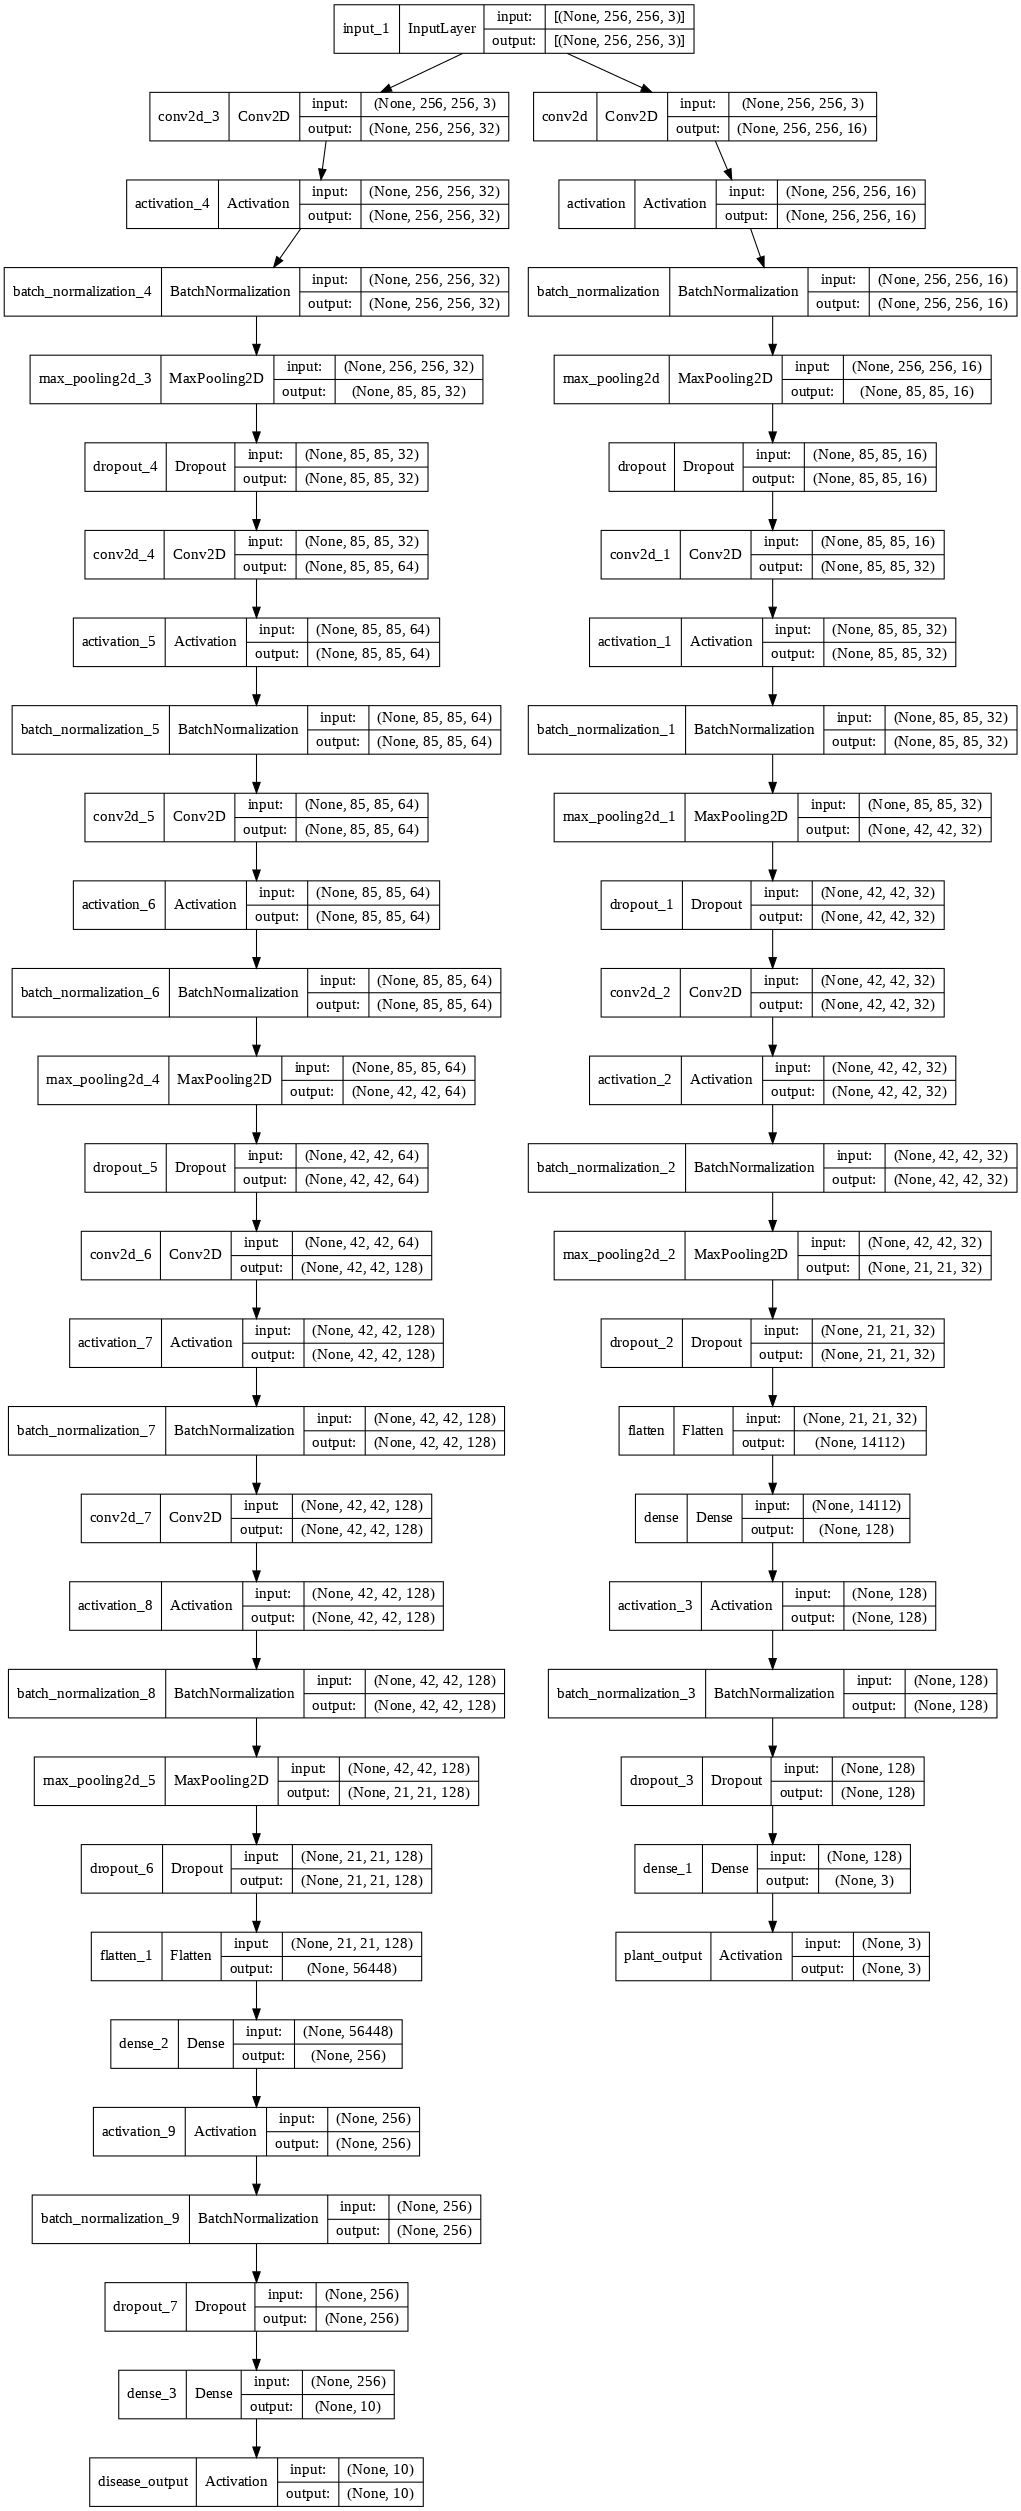

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [ ]:
model.summary()

Model: "plant_village"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation_4 (Activation)      (None, 256, 256, 32  0           ['conv2d_3[0][0]']               
                                )                                                     

#### Model Metrics , losses


In [ ]:
METRICS = [
      'accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
	"disease_output": "categorical_crossentropy",
	"plant_output": "categorical_crossentropy",
}
lossWeights = {"disease_output": 1.0, "plant_output": 1.0}

def get_callbacks():
  
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                            mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  # # define checkpoints

  # checkpoint_path = working_dir + "/" + name + "/checkpoints/cp.ckpt"
  # checkpoint_dir = os.path.dirname(checkpoint_path)

  # # Create a callback that saves the model's weights
  # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
  #                                                 save_weights_only=True,
  #                                                 verbose=1)
  return [reduce_lr, early_stop]#, cp_callback]

#### Model Compile

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, 
              loss=losses, 
              loss_weights=lossWeights, 
              metrics=METRICS
              )

## Run Classification

In [ ]:
# train the network to perform multi-output classification
H = model.fit(x=train_dataset, validation_data=val_dataset, epochs=EPOCHS, verbose=1)
# save the model to disk
print("[INFO] serializing network...")
model.save(f"{working_dir}\planview", save_format="h5")

Epoch 1/50
465/465 [==============================] - 132s 253ms/step - loss: 1.7585 - disease_output_loss: 1.2037 - plant_output_loss: 0.5548 - disease_output_accuracy: 0.6080 - disease_output_precision: 0.7034 - disease_output_recall: 0.5183 - disease_output_tp: 7701.0000 - disease_output_fp: 3247.0000 - disease_output_tn: 130475.0000 - disease_output_fn: 7157.0000 - disease_output_prc: 0.6684 - plant_output_accuracy: 0.7907 - plant_output_precision: 0.8179 - plant_output_recall: 0.7601 - plant_output_tp: 11294.0000 - plant_output_fp: 2515.0000 - plant_output_tn: 27201.0000 - plant_output_fn: 3564.0000 - plant_output_prc: 0.8731 - val_loss: 10.7854 - val_disease_output_loss: 6.8403 - val_plant_output_loss: 3.9451 - val_disease_output_accuracy: 0.2339 - val_disease_output_precision: 0.2432 - val_disease_output_recall: 0.2323 - val_disease_output_tp: 863.0000 - val_disease_output_fp: 2685.0000 - val_disease_output_tn: 30750.0000 - val_disease_output_fn: 2852.0000 - val_disease_output_p

OSError: ignored

In [ ]:
model.save(f"{working_dir}/plantview", save_format="h5") 

In [ ]:
working_dir

'/content/drive/MyDrive/Colab Notebooks/PlantView'

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 3), {disease_output: (None, 10), plant_output: (None, 3)}), types: (tf.float32, {disease_output: tf.int64, plant_output: tf.int64})>

##Model Evaluation

In [ ]:
def plot_confusion_matrix(true_labels, predictions_class, classes):
  lb = LabelBinarizer()
  lb.fit(classes)
  predictions_class = lb.inverse_transform(predictions)
  y_true_labels = lb.inverse_transform(true_labels)
  cm = confusion_matrix(true_labels, predictions_class, labels=classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()
  cls_report = classification_report(true_labels, predictions_class, output_dict=True)
  display(pd.DataFrame(cls_report))

In [ ]:
plot_confustion_matrix()

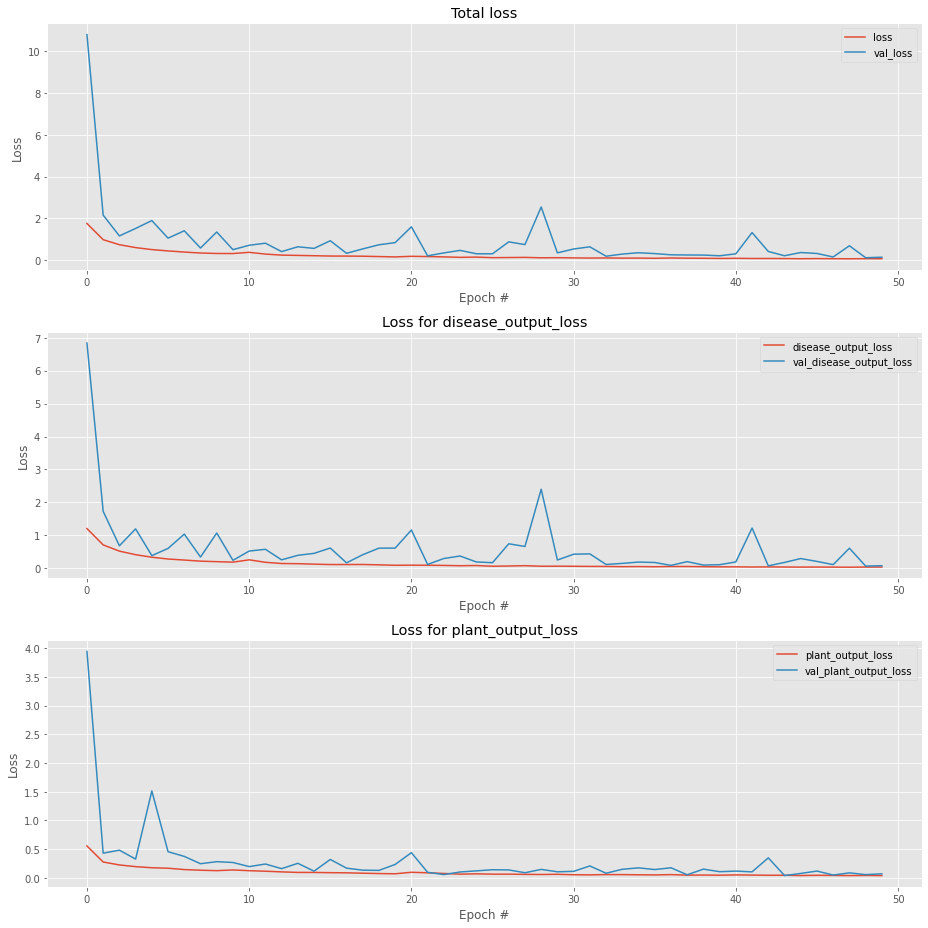

In [ ]:
# plot the total loss, category loss, and color loss
loss_names = ["loss", "disease_output_loss", "plant_output_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(loss_names):
  # plot the loss for both the training and validation data
  title = "Loss for {}".format(l) if l != "loss" else "Total loss"
  ax[i].set_title(title)
  ax[i].set_xlabel("Epoch #")
  ax[i].set_ylabel("Loss")
  ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
  ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
    label="val_" + l)
  ax[i].legend()
# save the losses figure
plt.tight_layout()
# plt.savefig("{}_losses.png".format(args["plot"]))
# plt.close()

In [ ]:
def plot_metric(metric_name, metric_outputs):
  # create a new figure for the accuracies
  # accuracy_names = ["disease_output_accuracy", "plant_output_accuracy"]
  plt.style.use("ggplot")
  (fig, ax) = plt.subplots(2, 1, figsize=(13, 9))
  # loop over the accuracy names
  for (i, l) in enumerate(metric_outputs):
    # plot the loss for both the training and validation data
    ax[i].set_title(l)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel(metric_name)
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
      label="val_" + l)
    ax[i].legend()
  # save the accuracies figure
  plt.tight_layout()
  # plt.savefig("{}_accs.png".format(args["plot"]))
  # plt.close()

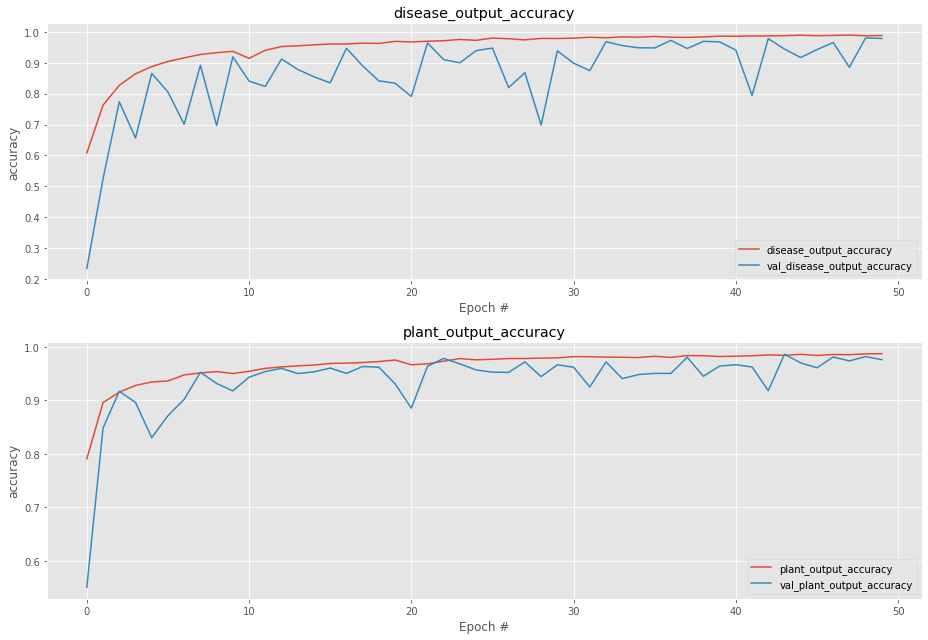

In [ ]:
plot_metric("accuracy", ["disease_output_accuracy", "plant_output_accuracy"])

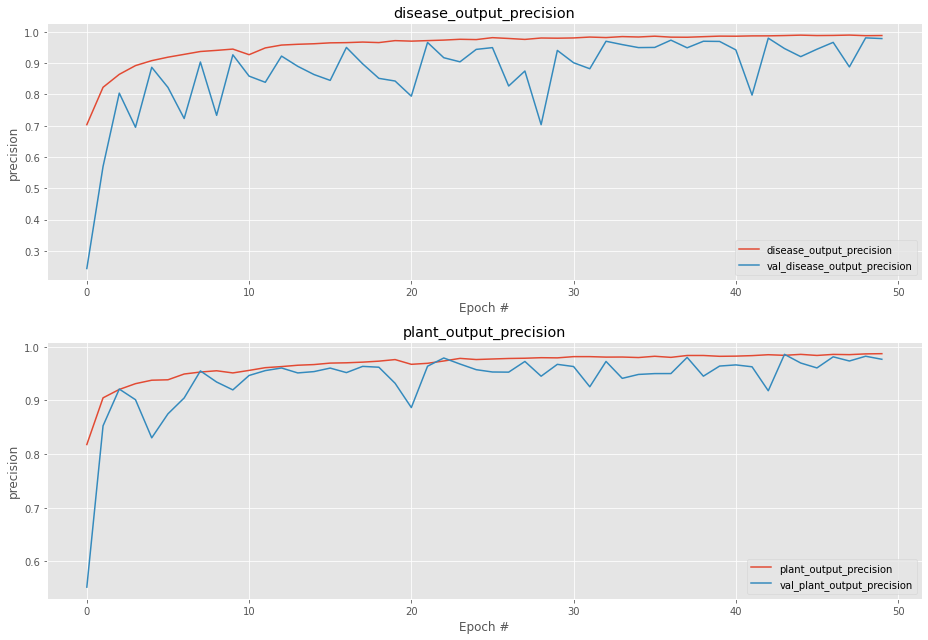

In [ ]:
plot_metric("precision", ["disease_output_precision","plant_output_precision"])

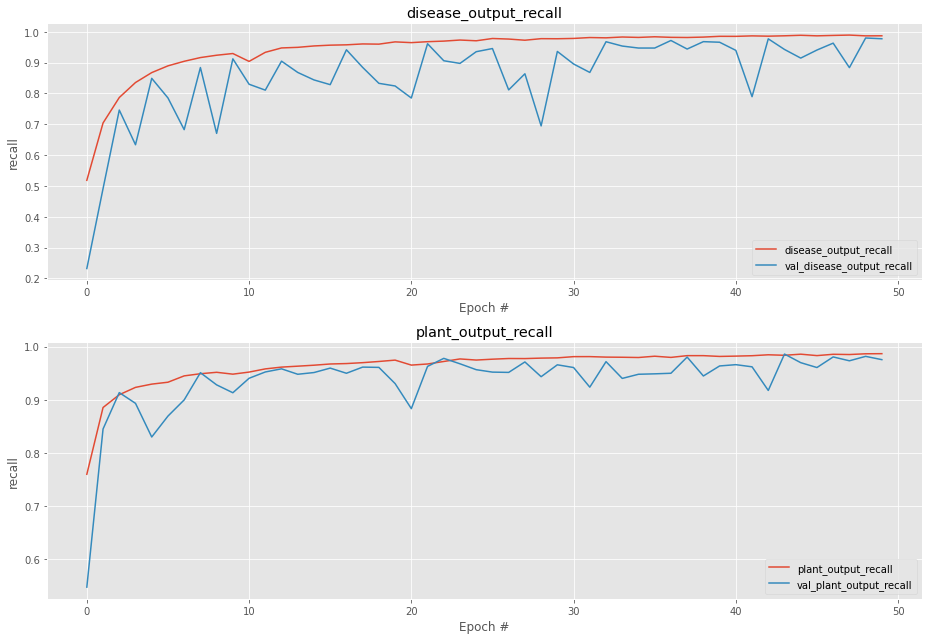

In [ ]:
plot_metric("recall", ["disease_output_recall", "plant_output_recall"])

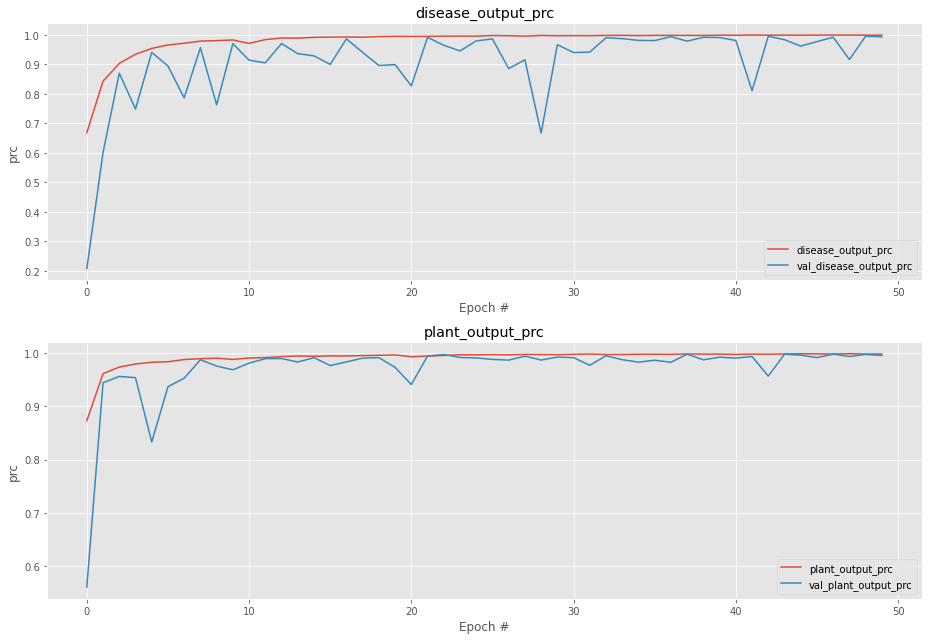

In [ ]:
plot_metric("prc", ["disease_output_prc", "plant_output_prc"])

In [ ]:
testX.shape

(2064, 4)

In [ ]:
for file_path in testX.file_path:
  print(file_path)

In [ ]:
testX.file_path.iloc[0]

'/content/data/PlantVillage/Tomato_Bacterial_spot/ecc30297-bfb6-4e9e-8b3e-f29ca20cffa7___UF.GRC_BS_Lab Leaf 8904.JPG'

In [ ]:
img1, _ = load_images(testX.file_path.iloc[0])

In [ ]:
img1.shape

TensorShape([256, 256, 3])

In [ ]:
type(img1)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
res = model.predict(tf.expand_dims(img1, axis=0))

In [ ]:
disease_LB.inverse_transform(res[0])

array(['bacterial_spot'], dtype='<U18')

In [ ]:
plant_LB.inverse_transform(res[1])

array(['tomato'], dtype='<U6')

In [ ]:
testX.iloc[0]

plant                                                   tomato
disease                                         bacterial_spot
file_path    /content/data/PlantVillage/Tomato_Bacterial_sp...
directory                                Tomato_Bacterial_spot
Name: 6213, dtype: object

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((testX.file_path))

test_dataset = (test_dataset
                 .map(load_images, 
                      num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE)
               )

In [ ]:
test_dataset

<PrefetchDataset shapes: ((None, 256, 256, 3), NoneTensorSpec()), types: (tf.float32, NoneTensorSpec())>

In [ ]:
predictions = model.predict(test_dataset)

In [ ]:
predictions[1].shape

(2064, 3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def plot_confusion_matrix(true_labels, predictions, classes):

  cm = confusion_matrix(true_labels, predictions, labels=classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()
  plt.grid(False)
  cls_report = classification_report(true_labels, predictions, output_dict=True)
  display(pd.DataFrame(cls_report))

bacterial_spot  curl_virus  ...    macro avg  weighted avg
precision        0.992883    0.984520  ...     0.908440      0.910720
recall           0.891374    0.990654  ...     0.885181      0.899225
f1-score         0.939394    0.987578  ...     0.888598      0.897270
support        313.000000  321.000000  ...  2064.000000   2064.000000

[4 rows x 13 columns]

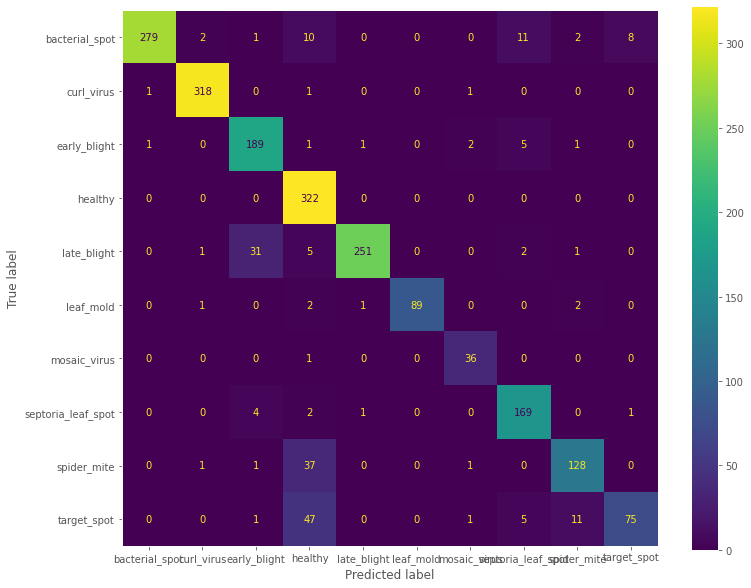

In [ ]:
plot_confusion_matrix(testX.disease, 
                      disease_LB.inverse_transform(predictions[0]), 
                      disease_cls)

pepper      potato  ...    macro avg  weighted avg
precision    0.913223    0.875000  ...     0.924193      0.964754
recall       0.965066    0.886878  ...     0.942180      0.964147
f1-score     0.938429    0.880899  ...     0.932927      0.964348
support    229.000000  221.000000  ...  2064.000000   2064.000000

[4 rows x 6 columns]

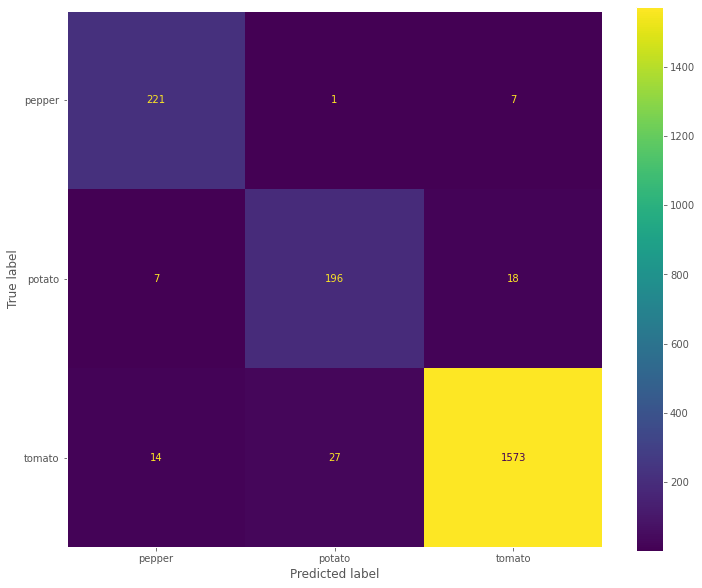

In [ ]:
plot_confusion_matrix(testX.plant, 
                      plant_LB.inverse_transform(predictions[1]), 
                      plant_cls)